# Computational Finance

## Lab Assignment 2

This notebook makes use of python 3 environment by default.

Authors:
   - Kevin de Vries
   - Jedda Boyle
   - Krishnakanth Sasi
   
Student Numbers:
   - 10579869
   - 11398221
   - 11391952

In [46]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.sparse import diags
from scipy.stats import norm
from numpy.linalg import inv

In [47]:
class PDE(object):
    def __init__(self, S0, K, sigma, r, T, S_bounds, N, M, scheme, boundary):
        """
        Initializes the PDE object
        
        sigma: float
            Volatility
        r: float
            Risk free interest rate
        T: integer/float
            Time until maturity
        S_bounds: tuple
            (minimum, maximum) stock price
        N: integer
            Number of time nodes
        M: integer
            Number of space nodes
        scheme: String
            String containing the Finite Difference scheme to use
        boundary: String
            String containing the boundary value type to use
        """
        
        # Set parameters
        self.sigma = sigma
        self.r = r
        self.K = K
        self.T = T
        
        # Calculate time steps
        self.dtau = T / N
        
        # Calculate boundaries of X and step size of X
        self.Xmin, self.Xmax = np.log(S_bounds[0]), np.log(S_bounds[1])
        self.dx = (self.Xmax-self.Xmin) / M
        
        # Set dimensions of the mesh grid
        self.N = N
        self.M = M
        
        # Set scheme type
        self.scheme = scheme
        
        # Set boundary value type
        self.boundary = boundary
        
        # Initialize Value matrix and calculate initial values
        self.V = np.zeros((M,N+1))
        self.V[:,0] = np.maximum(np.exp(self.Xmin + self.dx*np.arange(1,M+1)) - K, 0)
        
        
    def run(self):
        """
        Run the finite difference solver
        """
        
        # Set parameters
        r = self.r
        K = self.K
        T = self.T
        dx = self.dx
        dtau = self.dtau
        
        self.create_params()
        
        amin , a0, aplus = self.a
        bmin, b0, bplus = self.b
        
        if scheme == "Crank_Nicolson":
            self.BMatrix()
        
        t = T
        for n in range(1,self.N+1):
            
            if self.boundary == "Dirichlet":
                # Boundary value
                Vmax = np.exp(self.Xmax+dx) - K*np.exp(-r*t)
            elif self.boundary == "Von Neumann":
                pass
            
            self.V[:,n] = self.AprodV(self.V[:,n-1])
            self.V[-1, n] += aplus*Vmax
            
            if scheme == "Crank_Nicolson":
                self.V[-1, n] -= bplus*Vmax
                #self.V[:,n] = np.linalg.solve(self.B, self.V[:,n])
                self.V[:,n] = self.Binv @ self.V[:,n]
            
            t -= dtau

In [48]:
# Krish's functions section

def create_params(self):
    """
    Creates and stores a and b parameters as tuples in self
    """
    
    # Shorten object parameters
    r = self.r
    sigma = self.sigma
    dtau = self.dtau
    dx = self.dx
    
    AF0 = 1 - (sigma**2)*dtau/dx**2 - r*dtau
    P1 = -(r - 0.5*(sigma**2))*dtau/(2*dx) + 0.5*(sigma**2)*dtau/dx**2
    P2 = (r - 0.5*(sigma**2))*dtau/(2*dx) + 0.5*(sigma**2)*dtau/dx**2
    AC0 = 1 - 0.5*(sigma**2)*dtau/dx**2 - 0.5*r*dtau
    BC0 = 1 + 0.5*(sigma**2)*dtau/dx**2 + 0.5*r*dtau
    if self.scheme == "FTCS":
        self.a = [P1, AF0, P2]
        self.b = [0, 1, 0]
    if self.scheme == "Crank_Nicolson":
        self.a = [P1*0.5, AC0, P2*0.5]
        self.b = [-P1*0.5, BC0, -P2*0.5]

def BMatrix(self):
    """
    Creates and stores inverse of a B matrix in an object
    """
    bminus, b0 , bplus = self.b
    
    diagonals = [b0*np.ones(self.M), bplus*np.ones(self.M-1), bminus*np.ones(self.M-1)]
    
    self.B = diags(diagonals, [0, 1, -1]).toarray()
    self.Binv = inv(self.B)

In [49]:
# Kevin's code section

def AprodV(self,v):
    """
    Calculates the sparse matrix product of A with v
    """
    amin, a0, aplus = self.a
    
    res = np.zeros(v.size)
    
    # Calculate v_1 and v_M using boundary conditions
    res[0] = a0*v[0] + aplus*v[1]
    res[v.size-1] = amin*v[-2] + a0*v[-1]
    
    # Calculate the rest of the fucking vector
    res[1:v.size-1] = amin*v[:v.size-2] + a0*v[1:v.size-1] + aplus*v[2:]
    return res

def get_values(self):
    return np.copy(self.V[:,-1])

def get_stock_prices(self):
    return np.exp(self.Xmin + self.dx*np.arange(1,M+1))

In [50]:
PDE.create_params = create_params
PDE.BMatrix = BMatrix
PDE.AprodV = AprodV
PDE.get_values = get_values
PDE.get_stock_prices = get_stock_prices

In [51]:
# Misc functions

# Black Scholes formula
def black_scholes(r, K, T, S_0, sigma, call=True):
    '''
    Calculates the Hedge ratio, call or put price
    
    Parameters
        r: float
            Interest rate
        K: float
            Strike price
        T: int
            Time of maturity
        S_0: float
            Current stock price
        sigma: float
            Volatility
        call: bool
            check if call or put
        
    Returns
        delta: float
            Hedge ratio
        price: float
            Call or put price
    '''
    d1 = (np.log(S_0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*(T**0.5) 
    N1 = norm.cdf(d1)
    N2 = norm.cdf(d2)
    N3 = norm.cdf(-d1)
    N4 = norm.cdf(-d2)
    
    if call:
        price = S_0*N1 - K*np.exp(-r*T)*N2
        delta = N1
    else:
        price = K*np.exp(-r*T)*N4 - S_0*N3
        delta = N1 - 1
    
    return delta, price 

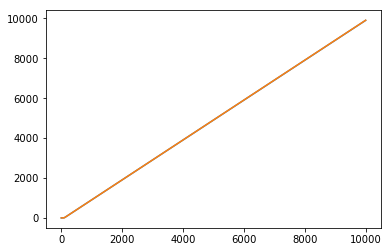

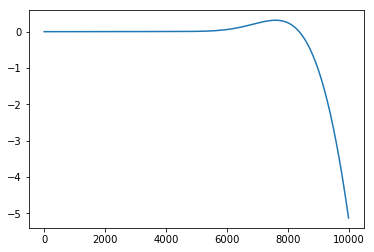

In [54]:
sigma,r,T = 0.2, 0.06, 1
S0, K = 100, 99
S_bounds = 0.00001, 10000
N, M = 2000, 2000
scheme = "Crank_Nicolson"
#scheme = "FTCS"

boundary = "Dirichlet"

test = PDE(S0, K, sigma, r, T, S_bounds, N, M, scheme, boundary)

test.run()

S = test.get_stock_prices()
V = test.get_values()

plt.plot(S,V)

BS_delta, BS_price = black_scholes(r, K, T, S, sigma)

plt.plot(S,BS_price)
plt.show()

plt.plot(S,V-BS_price)
plt.show()

In [55]:
idx = 1554

print("Stock price at t = 0: %f\n" % S[idx])
print("PDE price: %f\n" % V[idx])

print("Black-Scholes price: %f" % BS_price[idx])

Stock price at t = 0: 99.426007

PDE price: 11.160556

Black-Scholes price: 11.160549
